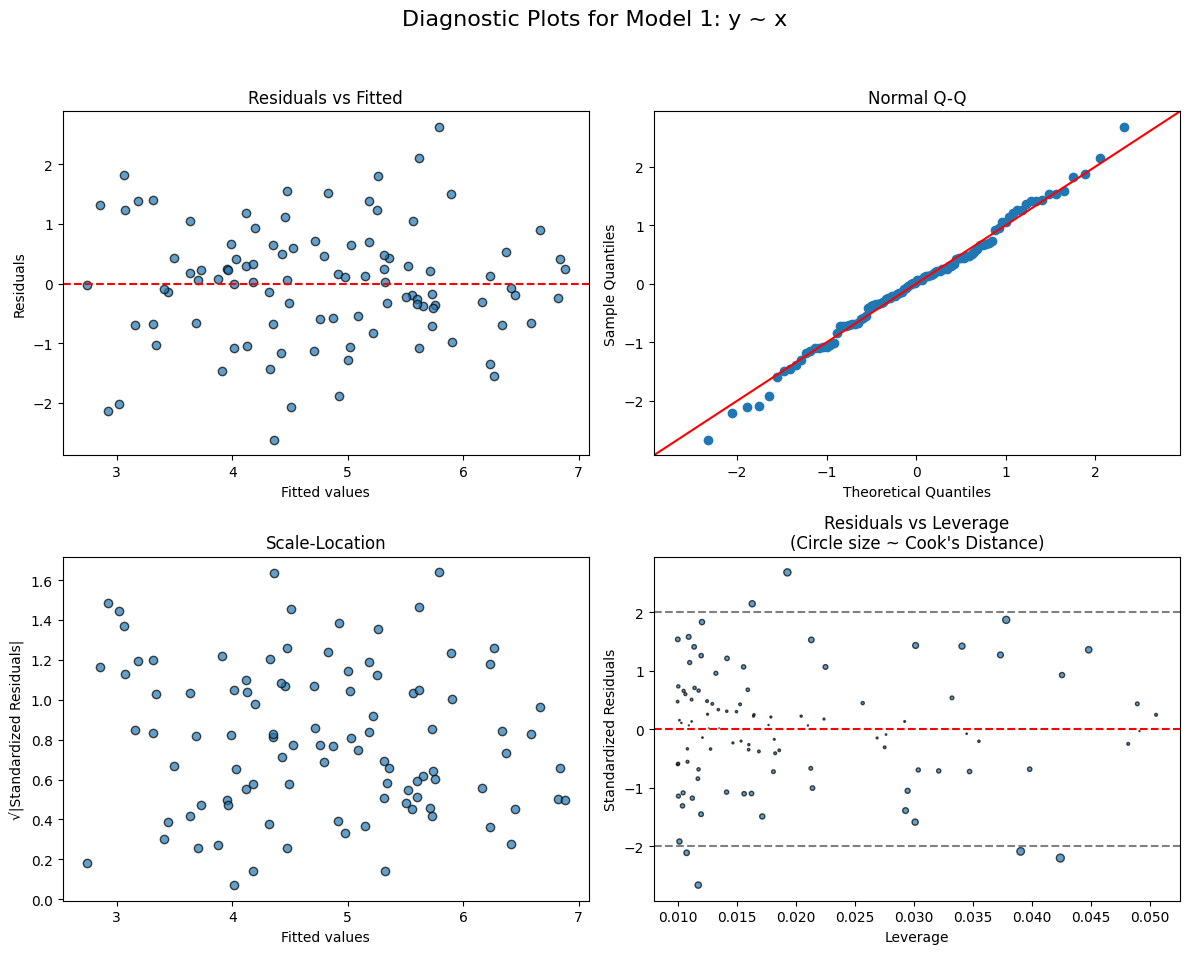

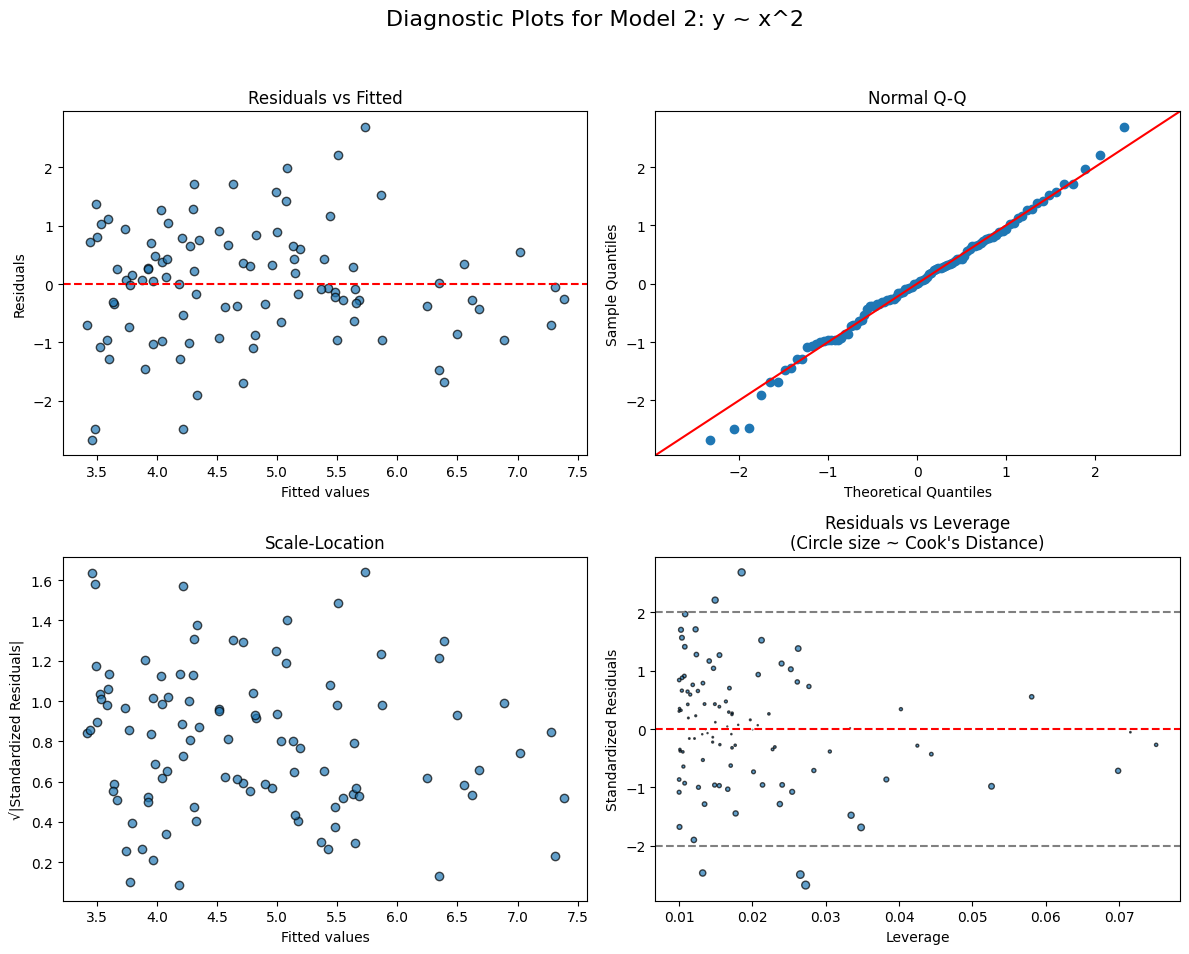

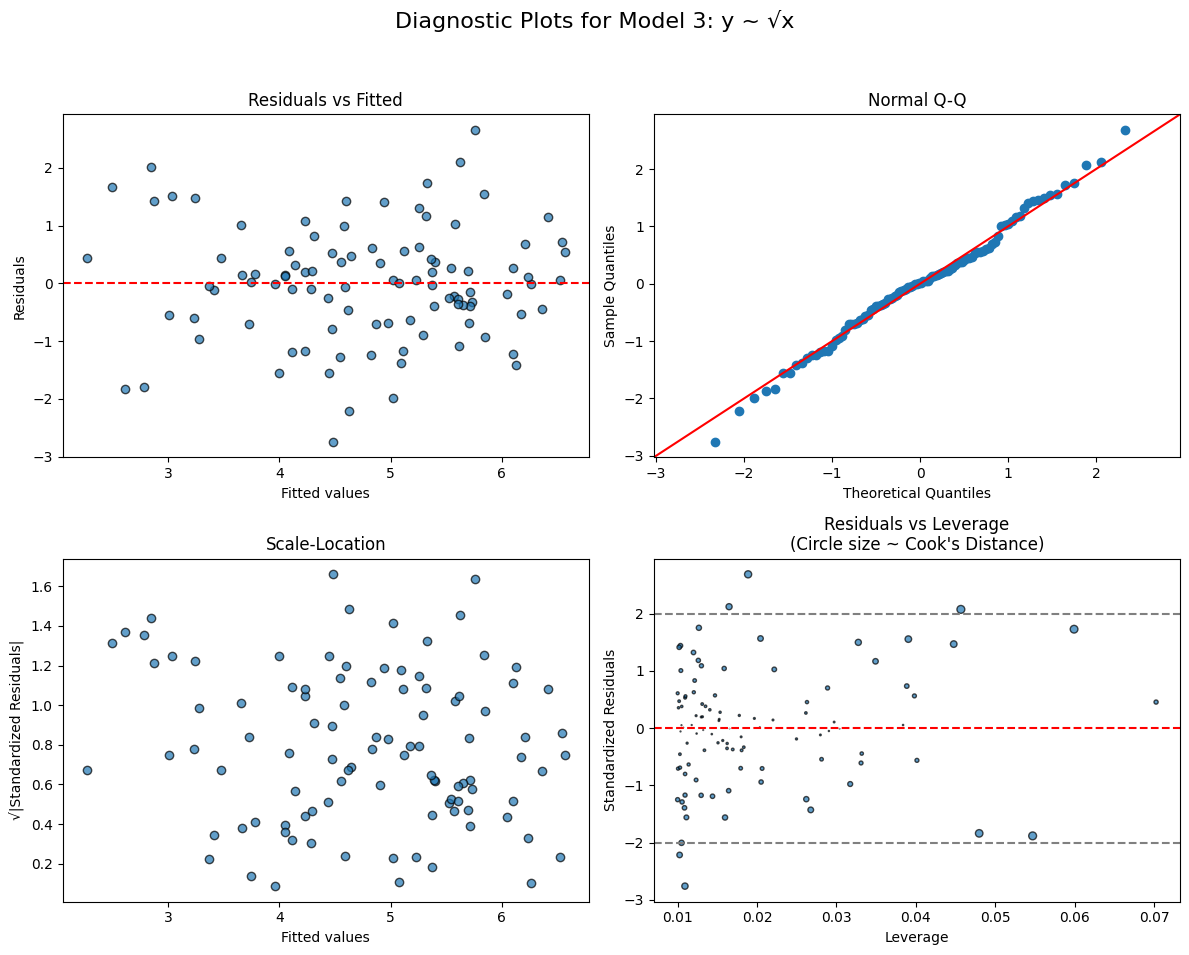

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

# 乱数シードの固定（再現性のため）
np.random.seed(123)

# -----------------------------
# 1. データ生成
# -----------------------------
n = 100
# xは1以上10以下の一様乱数
x = np.random.uniform(1, 10, n)

# 真のパラメータ
alpha_true = 2
beta_true = 0.5

# 正規乱数（標準偏差1）の誤差項
epsilon = np.random.normal(0, 1, n)

# 真のモデル： y = 2 + 0.5*x + ε
y = alpha_true + beta_true * x + epsilon

# DataFrameにまとめる
df = pd.DataFrame({'x': x, 'y': y})
# モデル用に各変換した説明変数を作成
df['x_sq'] = df['x']**2         # Model 2用：x^2
df['x_sqrt'] = np.sqrt(df['x'])  # Model 3用：√x

# -----------------------------
# 2. 診断プロット作成用の関数定義
# -----------------------------
def diagnostic_plots(model, model_name):
    """
    与えられたstatsmodelsの回帰結果から、
    以下の4つの診断プロットを作成する：
      1. 残差 vs 予測値
      2. 標準化残差のNormal Q-Qプロット
      3. Scale-Locationプロット（√|標準化残差| vs 予測値）
      4. Leverage vs 標準化残差（点の大きさでCookの距離を反映）
    """
    # モデルから影響度などの診断統計量を取得
    influence = model.get_influence()
    std_resid = influence.resid_studentized_internal  # 標準化残差
    fitted_vals = model.fittedvalues               # 予測値
    residuals = model.resid                        # 残差
    sqrt_std_resid = np.sqrt(np.abs(std_resid))     # Scale-Location用
    leverage = influence.hat_matrix_diag           # Leverage値
    cooks = influence.cooks_distance[0]            # Cookの距離

    # プロット領域（2×2）を作成
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Diagnostic Plots for {model_name}", fontsize=16)
    
    # --- 1. Residuals vs Fitted ---
    axs[0, 0].scatter(fitted_vals, residuals, alpha=0.7, edgecolor='k')
    axs[0, 0].axhline(0, linestyle='--', color='red')
    axs[0, 0].set_xlabel("Fitted values")
    axs[0, 0].set_ylabel("Residuals")
    axs[0, 0].set_title("Residuals vs Fitted")
    
    # --- 2. Normal Q-Q プロット ---
    sm.qqplot(std_resid, line='45', ax=axs[0, 1], fit=True)
    axs[0, 1].set_title("Normal Q-Q")
    
    # --- 3. Scale-Location プロット ---
    axs[1, 0].scatter(fitted_vals, sqrt_std_resid, alpha=0.7, edgecolor='k')
    axs[1, 0].set_xlabel("Fitted values")
    axs[1, 0].set_ylabel("√|Standardized Residuals|")
    axs[1, 0].set_title("Scale-Location")
    
    # --- 4. Leverage vs Standardized Residuals (点の大きさでCook's Distanceを反映) ---
    # Cookの距離が大きいほど点のサイズを大きくする（※ここでは大きさはCookの距離の平方根×100で調整）
    sizes = 100 * np.sqrt(cooks)
    sc = axs[1, 1].scatter(leverage, std_resid, s=sizes, alpha=0.7, edgecolor='k')
    axs[1, 1].set_xlabel("Leverage")
    axs[1, 1].set_ylabel("Standardized Residuals")
    axs[1, 1].set_title("Residuals vs Leverage\n(Circle size ~ Cook's Distance)")
    # 参考として、標準化残差が±2付近の水平線を追加
    axs[1, 1].axhline(0, linestyle='--', color='red')
    axs[1, 1].axhline(2, linestyle='--', color='gray')
    axs[1, 1].axhline(-2, linestyle='--', color='gray')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# -----------------------------
# 3. モデルのフィッティング
# -----------------------------

# モデル 1: y ~ x
X1 = sm.add_constant(df['x'])
model1 = sm.OLS(df['y'], X1).fit()

# モデル 2: y ~ x^2
X2 = sm.add_constant(df['x_sq'])
model2 = sm.OLS(df['y'], X2).fit()

# モデル 3: y ~ √x
X3 = sm.add_constant(df['x_sqrt'])
model3 = sm.OLS(df['y'], X3).fit()

# -----------------------------
# 4. 各モデルの診断プロットを作成
# -----------------------------
diagnostic_plots(model1, "Model 1: y ~ x")
diagnostic_plots(model2, "Model 2: y ~ x^2")
diagnostic_plots(model3, "Model 3: y ~ √x")
